# Image Captioning with Action Recognition Enhancement

This notebook implements an image captioning model with **Bahdanau Attention** and **Action Recognition** to improve caption accuracy.

## Key Features:
- **Dual Feature Extraction**: EfficientNetB0 for spatial features + Action recognition for semantic understanding
- **Bahdanau Attention**: Focus on relevant image regions
- **Action-Enhanced Decoder**: Captions informed by detected actions
- **Beam Search**: Generate high-quality captions

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from textwrap import wrap
import matplotlib.pyplot as plt


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Embedding, Dropout, Reshape,
                                     Bidirectional, LSTM, Concatenate, Layer,
                                     GlobalAveragePooling2D)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess

2026-01-04 05:04:27.108820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767503067.282188      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767503067.333871      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
image_path = "/kaggle/input/flickr8k/Images"

In [4]:
def readImage(path, image_size=224):
    img = load_img(path, target_size=(image_size, image_size))
    img = img_to_array(img)
    img = effnet_preprocess(img)
    return img

In [5]:
def display_images(temp_df, image_path, image_size=224):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(15,15))
    n = 0
    for i in range(min(len(temp_df), 15)):
        n += 1
        plt.subplot(5,5,n)
        plt.subplots_adjust(hspace = 0.7, wspace= 0.3)
        image = readImage(os.path.join(image_path, temp_df['image'][i]), image_size=image_size)
        img_disp = (image - image.min()) / (image.max() - image.min())
        plt.imshow(img_disp.astype(np.float32))
        plt.title("\n".join(wrap(temp_df['caption'][i], 25)))
        plt.axis('off')
    plt.show()

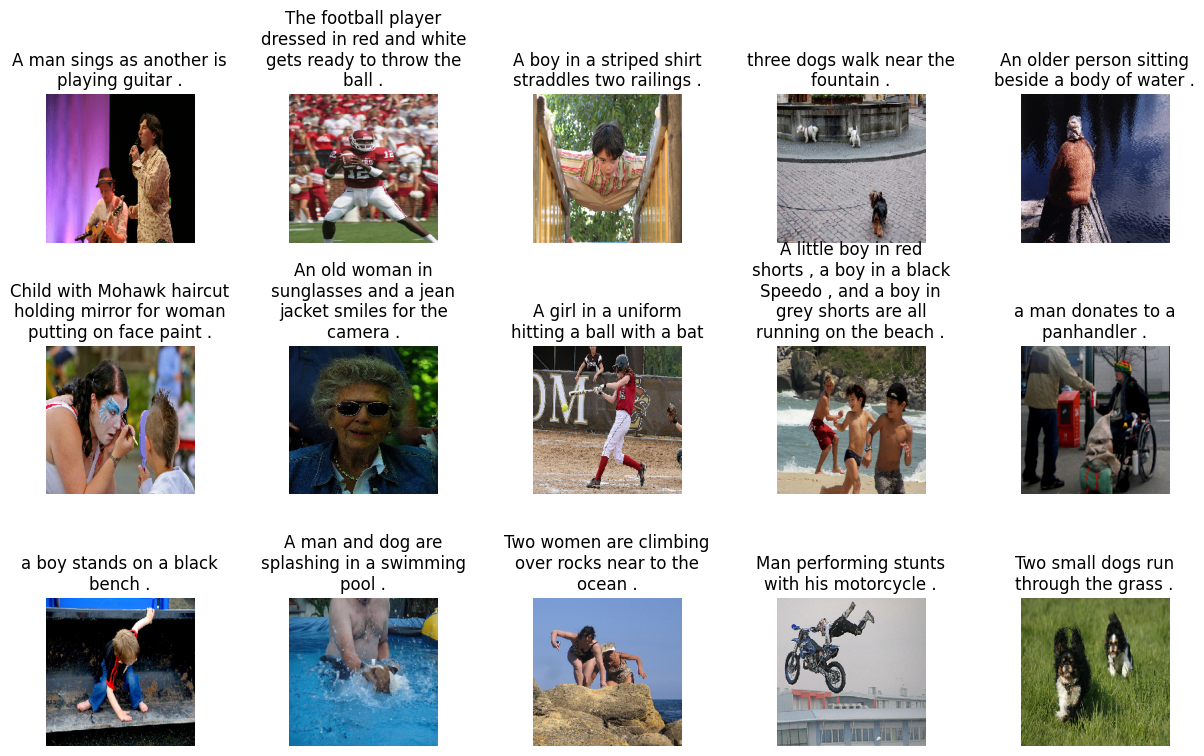

In [6]:
display_images(data.sample(15), image_path)

In [7]:
import re
def text_preprocessing(df, caption_col='caption'):
    df[caption_col] = df[caption_col].astype(str).str.strip()
    df[caption_col] = df[caption_col].str.lower()
    df[caption_col] = df[caption_col].apply(lambda x: re.sub(r"[^a-z0-9\s\.,'!?-]", "", x))
    df[caption_col] = df[caption_col].apply(lambda x: "startseq " + x.strip() + " endseq")
    return df


In [8]:
data = text_preprocessing(data) 

In [9]:
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,startseq a child in a pink dress is climbing u...
1,1000268201_693b08cb0e.jpg,startseq a girl going into a wooden building ....
2,1000268201_693b08cb0e.jpg,startseq a little girl climbing into a wooden ...
3,1000268201_693b08cb0e.jpg,startseq a little girl climbing the stairs to ...
4,1000268201_693b08cb0e.jpg,startseq a little girl in a pink dress going i...


In [10]:
captions = data['caption'].tolist()

In [11]:
tokenizer = Tokenizer(oov_token=None)  
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocab size: {vocab_size}")

Vocab size: 8496


In [12]:
max_length = max(len(c.split()) for c in captions)
print(f"Max caption length: {max_length}")

Max caption length: 40


In [13]:
images = data['image'].unique().tolist()
nimages = len(images)
print(f"Number of unique images: {nimages}")
split_index = round(nimages * 0.85)
train_images = images[:split_index]
val_images = images[split_index:]
train = data[data['image'].isin(train_images)].reset_index(drop=True)
val = data[data['image'].isin(val_images)].reset_index(drop=True)

Number of unique images: 8091


In [14]:
train

,image,caption
0,1000268201_693b08cb0e.jpg,startseq a child in a pink dress is climbing u...
1,1000268201_693b08cb0e.jpg,startseq a girl going into a wooden building ....
2,1000268201_693b08cb0e.jpg,startseq a little girl climbing into a wooden ...
3,1000268201_693b08cb0e.jpg,startseq a little girl climbing the stairs to ...
4,1000268201_693b08cb0e.jpg,startseq a little girl in a pink dress going i...
...,...,...
34380,3688839836_ba5e4c24fc.jpg,startseq a woman is holding out a peace sign d...
34381,3688839836_ba5e4c24fc.jpg,startseq a woman wearing a red scarf raises he...
34382,3688839836_ba5e4c24fc.jpg,startseq people in orange shirts marching down...
34383,3688839836_ba5e4c24fc.jpg,startseq the woman in the red shirt is holding...


In [15]:
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [ ]:
# ====================================================
# Action Recognition Model Setup
# ====================================================
# We'll use MobileNetV2 trained on ImageNet as action recognizer
# ImageNet has 1000 classes including many action-related categories
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

# Load action recognition model (MobileNetV2 for actions)
action_model_base = MobileNetV2(weights='imagenet', include_top=True, input_shape=(img_size, img_size, 3))
# Get features before final classification (1280-dim feature vector)
action_fe_model = Model(inputs=action_model_base.input, 
                        outputs=action_model_base.get_layer('global_average_pooling2d').output)
print("✅ Action recognition model (MobileNetV2) loaded!")
print(f"   Action feature dimension: {action_fe_model.output.shape[-1]}")

In [16]:
img_size = 224

In [17]:
base_model = EfficientNetB0(weights='imagenet', include_top = False, input_shape = (img_size, img_size, 3))
fe_model = Model(inputs = base_model.input, outputs = base_model.output)

I0000 00:00:1767503080.920515      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def readImageForAction(path, image_size=224):
    """Read and preprocess image for MobileNetV2 action recognition"""
    img = load_img(path, target_size=(image_size, image_size))
    img = img_to_array(img)
    img = mobilenet_preprocess(img)
    return img

In [18]:
features = {}
for image in tqdm(data['image'].unique().tolist(), desc="Extracting features"):
    img = readImage(os.path.join(image_path, image), image_size=img_size)
    img = np.expand_dims(img, axis=0)
    feat_map = fe_model.predict(img, verbose=0)
    feat_map = feat_map[0]
    h, w, c = feat_map.shape
    feat_reshaped = feat_map.reshape(-1, c)
    features[image] = feat_reshaped.astype(np.float32)

Extracting features:   0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1767503086.690552     102 service.cc:148] XLA service 0x7b6c28001990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767503086.691250     102 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1767503087.355590     102 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1767503091.116988     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Extracting features: 100%|██████████| 8091/8091 [11:26<00:00, 11.79it/s]


In [ ]:
# Extract action features for all images
action_features = {}
for image in tqdm(data['image'].unique().tolist(), desc="Extracting action features"):
    img = readImageForAction(os.path.join(image_path, image), image_size=img_size)
    img = np.expand_dims(img, axis=0)
    action_feat = action_fe_model.predict(img, verbose=0)
    action_features[image] = action_feat[0].astype(np.float32)  # 1280-dim vector

print(f"✅ Action features extracted! Shape: {next(iter(action_features.values())).shape}")

In [19]:
sample_feature = next(iter(features.values()))
num_patches, feat_dim = sample_feature.shape
print("num_patches:", num_patches, "feat_dim:", feat_dim)

num_patches: 49 feat_dim: 1280


In [20]:
with open("features_effnetb7.pkl", "wb") as f:
    pickle.dump(features, f)


In [ ]:
with open("action_features.pkl", "wb") as f:
    pickle.dump(action_features, f)
print("✅ Action features saved!")

In [21]:
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

In [22]:
with open("features_effnetb7.pkl", "rb") as f:
    features = pickle.load(f)

In [ ]:
with open("action_features.pkl", "rb") as f:
    action_features = pickle.load(f)
print("✅ Action features loaded!")

In [ ]:
class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, tokenizer, vocab_size, max_length, 
                 features_dict, action_features_dict, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features_dict
        self.action_features = action_features_dict
        self.shuffle = shuffle
        self.n = len(self.df)
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    def __len__(self):
        return int(np.ceil(self.n / float(self.batch_size)))
    @property
    def num_batches(self):
        return self.__len__()
    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, X3, y = self.__get_data(batch)
        return (X1, X2, X3), y
    def __get_data(self, batch):
        X1, X2, X3, y = [], [], [], []
        images = batch[self.X_col].unique().tolist()
        
        for _, row in batch.iterrows():
            image = row[self.X_col]
            caption = row[self.y_col]
            feature = self.features[image]   
            action_feat = self.action_features[image]
            seq = self.tokenizer.texts_to_sequences([caption])[0]
            
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length, padding='post')[0]
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                X1.append(feature)   
                X2.append(in_seq)
                X3.append(action_feat)
                y.append(out_seq)
        
        X1 = np.array(X1)  
        X2 = np.array(X2)
        X3 = np.array(X3)
        y  = np.array(y)   
        return X1, X2, X3, y

In [ ]:
class BahdanauAttention(Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)   
        self.W2 = Dense(units) 
        self.V  = Dense(1)     

    def call(self, encoder_features, decoder_hidden):
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)
        score = tf.nn.tanh(self.W1(encoder_features) + self.W2(decoder_hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * encoder_features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, tf.squeeze(attention_weights, -1)

In [ ]:
num_patches = sample_feature.shape[0]  
feat_dim = sample_feature.shape[1]
action_dim = 1280  # MobileNetV2 action features 

In [ ]:

encoder_input = Input(shape=(num_patches, feat_dim), name='image_features')
decoder_input = Input(shape=(max_length,), name='decoder_input')
action_input = Input(shape=(action_dim,), name='action_features')  # New action input

In [27]:
embedding_dim = 512
embed = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True, name='embed')(decoder_input)

In [28]:
bi_lstm = Bidirectional(LSTM(512, return_sequences=False, return_state=False), name='bilstm')(embed)

In [ ]:
attention_units = 512
attention = BahdanauAttention(attention_units)
context_vector, att_weights = attention(encoder_input, bi_lstm)

# Process action features
action_dense = Dense(256, activation='relu', name='action_dense')(action_input)
action_dropout = Dropout(0.3)(action_dense)

In [ ]:
concat = Concatenate(axis=-1)([context_vector, bi_lstm, action_dropout])  # Add action features
x = Dense(512, activation='relu')(concat)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(vocab_size, activation='softmax')(x)

In [ ]:
caption_model = Model(inputs=[encoder_input, decoder_input, action_input], outputs=outputs)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')
caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed (Embedding)   │ (None, 40, 512)   │  4,349,952 │ decoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 40)        │          0 │ decoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_features      │ (None, 49, 1280)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm              │ (None, 1024)      │  4,198,400 │ embed[0][0],      │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention  │ [(None, 1280),    │  1,181,185 │ image_features[0… │
│ (BahdanauAttention) │ (None, 49)]       │            │ bilstm[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2304)      │          0 │ bahdanau_attenti… │
│ (Concatenate)       │                   │            │ bilstm[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │  1,180,160 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8496)      │  2,183,472 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,224,497 (50.45 MB)

 Trainable params: 13,224,497 (50.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 32  
train_generator = CustomDataGenerator(df=train, X_col='image', y_col='caption', batch_size=batch_size,
                                      tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length,
                                      features_dict=features, action_features_dict=action_features, shuffle=True)
validation_generator = CustomDataGenerator(df=val, X_col='image', y_col='caption', batch_size=batch_size,
                                           tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length,
                                           features_dict=features, action_features_dict=action_features, shuffle=False)

In [33]:
model_name = "caption_trained_model.h5"
checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
earlystopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=1e-9, verbose=1)

In [34]:
history = caption_model.fit(
    train_generator,
    epochs=60,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, reduce_lr],
    verbose=1
)

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1075/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 4.8159
Epoch 1: val_loss improved from inf to 3.52853, saving model to caption_trained_model.h5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 179s 159ms/step - loss: 4.8154 - val_loss: 3.5285 - learning_rate: 0.0010
Epoch 2/60
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 3.5026
Epoch 2: val_loss improved from 3.52853 to 3.27391, saving model to caption_trained_model.h5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 170s 158ms/step - loss: 3.5026 - val_loss: 3.2739 - learning_rate: 0.0010
Epoch 3/60
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 3.1880
Epoch 3: val_loss improved from 3.27391 to 3.16510, saving model to caption_trained_model.h5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 168s 156ms/step - loss: 3.1880 - val_loss: 3.1651 - learning_rate: 0.0010
Epoch 4/60
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 2.9866
Epoch 4: val_loss improved from 3.16510 to 3.11530, saving model to caption_trained_model.h5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 171s 159ms/st

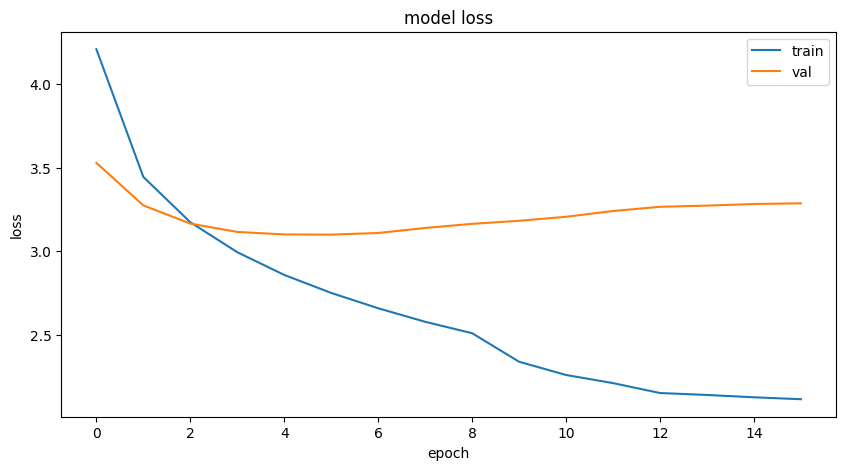

In [35]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


In [36]:

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [37]:
def clean_caption(raw_caption):
    caption = raw_caption.replace('startseq', '').replace('endseq', '').strip()
    caption = caption.capitalize()
    if not caption.endswith('.'):
        caption = caption + '.'
    return caption

In [ ]:
import math
def beam_search_predictions(model, tokenizer, feature, action_feat, max_length, beam_index=3):
    start_token = tokenizer.word_index.get('startseq')
    end_token = tokenizer.word_index.get('endseq')
    if start_token is None or end_token is None:
        raise ValueError("startseq/endseq tokens missing in tokenizer")
    sequences = [[ [start_token], 0.0 ]] 

    while True:
        all_candidates = []
        for seq, score in sequences:
            if seq[-1] == end_token or len(seq) >= max_length:
                all_candidates.append((seq, score))
                continue
            sequence = pad_sequences([seq], maxlen=max_length, padding='post')
            yhat = model.predict([feature[np.newaxis,...], sequence, action_feat[np.newaxis,...]], verbose=0)[0] 
            top_indices = np.argsort(yhat)[-beam_index:]
            for idx in top_indices:
                prob = yhat[idx]
                if prob <= 0:
                    continue
                candidate_seq = seq + [int(idx)]
                candidate_score = score + math.log(prob + 1e-10)
                all_candidates.append((candidate_seq, candidate_score))
        ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
        sequences = ordered[:beam_index]
        
        if any(s[-1] == end_token for s, _ in sequences):
            break
        
        if len(sequences[0][0]) >= max_length:
            break


    best_seq = sequences[0][0]
    
    words = [idx_to_word(i, tokenizer) for i in best_seq]

    caption = " ".join([w for w in words if w is not None])
    return clean_caption(caption)

def predict_caption_beam(model, image_key, tokenizer, max_length, features_dict, action_features_dict, beam_index=3):
    feature = features_dict[image_key]
    action_feat = action_features_dict[image_key]
    return beam_search_predictions(model, tokenizer, feature, action_feat, max_length, beam_index=beam_index)

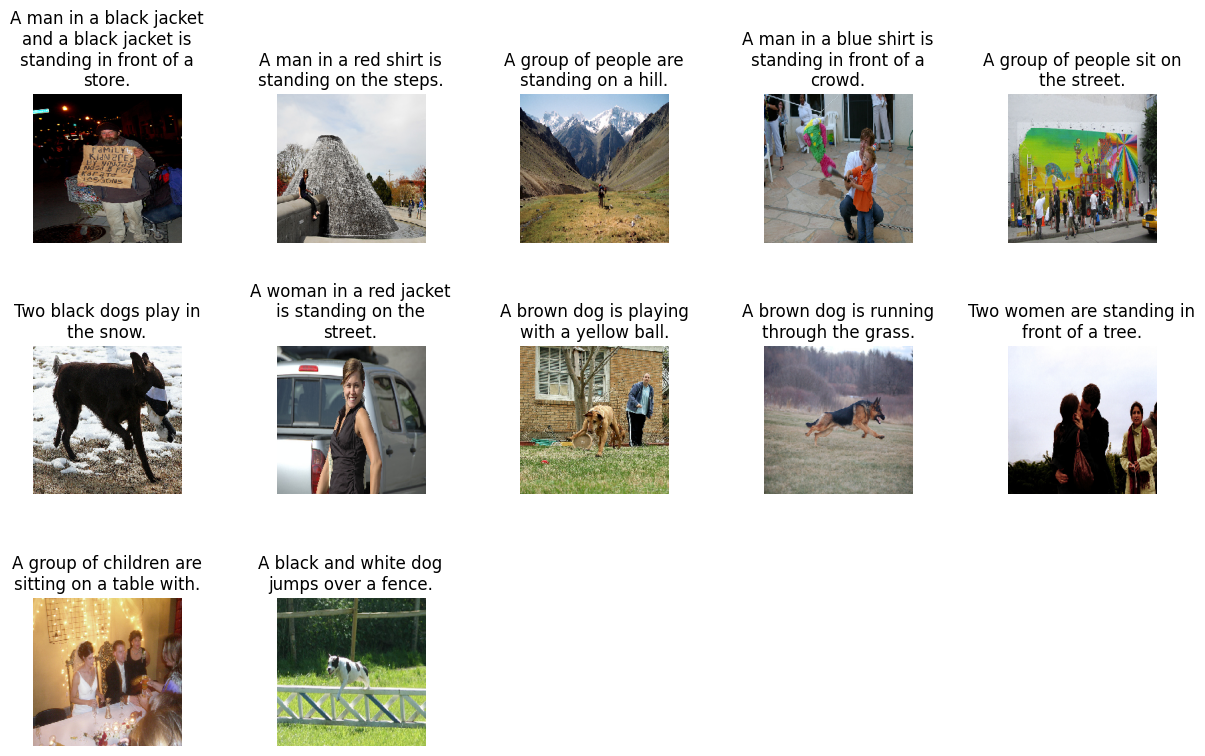

In [ ]:
samples = val.sample(12).reset_index(drop=True)
for idx, row in samples.iterrows():
    pred = predict_caption_beam(caption_model, row['image'], tokenizer, max_length, features, action_features, beam_index=3)
    samples.at[idx, 'caption'] = pred

display_images(samples, image_path, image_size=img_size)

In [ ]:
# ====================================================
# Test Model on Unseen Images with Trained Weights
# ====================================================

from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

# ====================================================
# STEP 1: Load all required components
# ====================================================

# Load tokenizer (REQUIRED for caption generation)
with open("/kaggle/working/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)
print(f"✅ Tokenizer loaded! Vocab size: {len(tokenizer.word_index) + 1}")

# Get vocab size and max_length from tokenizer
vocab_size = len(tokenizer.word_index) + 1
max_length = 40  # Set this to the max_length used during training

# Image size
img_size = 224
action_dim = 1280  # MobileNetV2 action feature dimension

# Load feature extraction model (EfficientNetB0 for spatial features)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
fe_model = Model(inputs=base_model.input, outputs=base_model.output)
print("✅ Feature extraction model (EfficientNetB0) loaded!")

# Load action recognition model (MobileNetV2 for action features)
action_model_base = MobileNetV2(weights='imagenet', include_top=True, input_shape=(img_size, img_size, 3))
# Get the GlobalAveragePooling layer (it's the second-to-last layer, before 'predictions')
action_fe_model = Model(inputs=action_model_base.input, 
                        outputs=action_model_base.layers[-2].output)
# Keep the full model for action predictions
action_classifier = action_model_base
print("✅ Action recognition model (MobileNetV2) loaded!")

# Define BahdanauAttention class (needed for loading the model)
class BahdanauAttention(Layer):
    def __init__(self, units, **kwargs):
        super(BahdanauAttention, self).__init__(**kwargs)
        self.units = units
        self.W1 = Dense(units)   
        self.W2 = Dense(units) 
        self.V  = Dense(1)     

    def call(self, encoder_features, decoder_hidden):
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)
        score = tf.nn.tanh(self.W1(encoder_features) + self.W2(decoder_hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * encoder_features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, tf.squeeze(attention_weights, -1)
    
    def get_config(self):
        config = super().get_config()
        config.update({"units": self.units})
        return config

# Rebuild model architecture with action recognition
def build_caption_model_architecture(vocab_size, max_length, num_patches, feat_dim, action_dim):
    """Rebuild the exact model architecture from training with action recognition"""
    # Input layers
    encoder_input = Input(shape=(num_patches, feat_dim), name='image_features')
    decoder_input = Input(shape=(max_length,), name='decoder_input')
    action_input = Input(shape=(action_dim,), name='action_features')
    
    # Embedding layer
    embedding_dim = 512
    embed = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True, name='embed')(decoder_input)
    
    # Bidirectional LSTM
    bi_lstm = Bidirectional(LSTM(512, return_sequences=False, return_state=False), name='bilstm')(embed)
    
    # Attention mechanism
    attention_units = 512
    attention = BahdanauAttention(attention_units)
    context_vector, att_weights = attention(encoder_input, bi_lstm)
    
    # Process action features
    action_dense = Dense(256, activation='relu', name='action_dense')(action_input)
    action_dropout = Dropout(0.3)(action_dense)
    
    # Decoder dense layers (concatenate visual context + LSTM + action)
    concat = Concatenate(axis=-1)([context_vector, bi_lstm, action_dropout])
    x = Dense(512, activation='relu')(concat)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(vocab_size, activation='softmax')(x)
    
    # Build model
    model = Model(inputs=[encoder_input, decoder_input, action_input], outputs=outputs)
    return model

# Get feature dimensions from a sample extraction
print("📦 Extracting sample features to determine dimensions...")
sample_img = np.zeros((1, img_size, img_size, 3))
sample_feat = fe_model.predict(sample_img, verbose=0)[0]
h, w, c = sample_feat.shape
num_patches = h * w  # Should be 49 for 7x7
feat_dim = c  # Should be 1280 for EfficientNetB0

print(f"   num_patches={num_patches}, feat_dim={feat_dim}, action_dim={action_dim}")

# Build model architecture
print("🏗️ Building model architecture with action recognition...")
caption_model = build_caption_model_architecture(vocab_size, max_length, num_patches, feat_dim, action_dim)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

# Load trained weights
weights_path = "caption_trained_model.h5"
try:
    caption_model.load_weights(weights_path)
    print(f"✅ Model weights loaded successfully from {weights_path}")
except Exception as e:
    print(f"❌ Error loading weights: {e}")
    caption_model = None

# ====================================================
# STEP 2: Define helper functions
# ====================================================

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def clean_caption(raw_caption):
    caption = raw_caption.replace('startseq', '').replace('endseq', '').strip()
    caption = caption.capitalize()
    if not caption.endswith('.'):
        caption = caption + '.'
    return caption

def beam_search_predictions_test(model, tokenizer, feature, action_feat, max_length, beam_index=3):
    """Beam search for caption generation with action features"""
    import math
    start_token = tokenizer.word_index.get('startseq')
    end_token = tokenizer.word_index.get('endseq')
    if start_token is None or end_token is None:
        raise ValueError("startseq/endseq tokens missing in tokenizer")
    sequences = [[[start_token], 0.0]]

    while True:
        all_candidates = []
        for seq, score in sequences:
            if seq[-1] == end_token or len(seq) >= max_length:
                all_candidates.append((seq, score))
                continue
            sequence = pad_sequences([seq], maxlen=max_length, padding='post')
            yhat = model.predict([feature[np.newaxis,...], sequence, action_feat[np.newaxis,...]], verbose=0)[0]
            top_indices = np.argsort(yhat)[-beam_index:]
            for idx in top_indices:
                prob = yhat[idx]
                if prob <= 0:
                    continue
                candidate_seq = seq + [int(idx)]
                candidate_score = score + math.log(prob + 1e-10)
                all_candidates.append((candidate_seq, candidate_score))
        ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
        sequences = ordered[:beam_index]
        
        if any(s[-1] == end_token for s, _ in sequences):
            break
        if len(sequences[0][0]) >= max_length:
            break

    best_seq = sequences[0][0]
    words = [idx_to_word(i, tokenizer) for i in best_seq]
    caption = " ".join([w for w in words if w is not None])
    return clean_caption(caption)

def extract_features_from_image(image_path, fe_model, img_size=224):
    """Extract spatial features from a single image using EfficientNetB0"""
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img)
    img = effnet_preprocess(img)
    img = np.expand_dims(img, axis=0)
    feat_map = fe_model.predict(img, verbose=0)
    feat_map = feat_map[0]
    h, w, c = feat_map.shape
    feat_reshaped = feat_map.reshape(-1, c)
    return feat_reshaped.astype(np.float32)

def extract_action_features(image_path, action_fe_model, img_size=224):
    """Extract action features from a single image using MobileNetV2"""
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img)
    img = mobilenet_preprocess(img)
    img = np.expand_dims(img, axis=0)
    action_feat = action_fe_model.predict(img, verbose=0)
    return action_feat[0].astype(np.float32)

def predict_action(image_path, action_classifier, img_size=224):
    """Predict action/object class from image using MobileNetV2"""
    from tensorflow.keras.applications.mobilenet_v2 import decode_predictions
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img)
    img = mobilenet_preprocess(img)
    img = np.expand_dims(img, axis=0)
    preds = action_classifier.predict(img, verbose=0)
    decoded = decode_predictions(preds, top=1)[0][0]
    return decoded[1], decoded[2]  # (class_name, confidence)

def predict_caption_for_image(image_path, caption_model, fe_model, action_fe_model, action_classifier, tokenizer, max_length, img_size=224, beam_index=3):
    """Generate caption for a single unseen image with action recognition"""
    # Extract spatial features
    feature = extract_features_from_image(image_path, fe_model, img_size)
    # Extract action features
    action_feat = extract_action_features(image_path, action_fe_model, img_size)
    # Predict action class
    action_name, action_conf = predict_action(image_path, action_classifier, img_size)
    # Generate caption using beam search
    caption = beam_search_predictions_test(caption_model, tokenizer, feature, action_feat, max_length, beam_index)
    return caption, action_name, action_conf

def test_on_unseen_images(image_paths, caption_model, fe_model, action_fe_model, action_classifier, tokenizer, max_length, img_size=224, beam_index=3):
    """
    Test the model on multiple unseen images and display results
    """
    if caption_model is None:
        print("❌ Cannot run predictions - model not loaded!")
        return
    
    n_images = len(image_paths)
    
    # Calculate grid size
    cols = min(3, n_images)
    rows = (n_images + cols - 1) // cols
    
    plt.figure(figsize=(6*cols, 6*rows))
    
    print("="*60)
    print("CAPTION PREDICTIONS WITH ACTION RECOGNITION")
    print("="*60)
    
    for i, img_path in enumerate(image_paths):
        # Check if file exists
        if not os.path.exists(img_path):
            print(f"\n❌ Image not found: {img_path}")
            continue
        
        # Generate caption and predict action
        caption, action_name, action_conf = predict_caption_for_image(
            img_path, caption_model, fe_model, action_fe_model, action_classifier, tokenizer, max_length, img_size, beam_index
        )
        
        # Print result
        print(f"\n📷 Image {i+1}: {os.path.basename(img_path)}")
        print(f"🎬 Predicted Action: {action_name.replace('_', ' ').title()} ({action_conf*100:.1f}% confidence)")
        print(f"📝 Generated Caption: {caption}")
        
        # Display image with caption and action
        plt.subplot(rows, cols, i+1)
        img = load_img(img_path, target_size=(img_size, img_size))
        plt.imshow(img)
        
        # Add text below image
        action_text = f"Predicted Action: {action_name.replace('_', ' ').title()}"
        caption_text = f"Caption: {caption}"
        plt.text(0.5, -0.15, action_text, ha='center', va='top', 
                transform=plt.gca().transAxes, fontsize=9, fontweight='bold', color='darkblue')
        plt.text(0.5, -0.25, caption_text, ha='center', va='top', 
                transform=plt.gca().transAxes, fontsize=8, wrap=True, color='darkgreen')
        plt.axis('off')
    
    print("\n" + "="*60)
    plt.tight_layout()
    plt.show()

# ====================================================
# STEP 3: Test on unseen images
# ====================================================
# Replace these paths with your actual unseen image paths

unseen_image_paths = [
    "/kaggle/input/test-folder/baseball.jpeg",
    "/kaggle/input/test-folder/basketball.jpg",
    "/kaggle/input/test-folder/horse_riding.jpeg",
    "/kaggle/input/test-folder/sking.jpeg",
    "/kaggle/input/test-folder/Dog_Race.jpg",
    "/kaggle/input/test-folder/people.avif",
    "/kaggle/input/test-folder/Hill.jpg"
]

# Run prediction on unseen images
test_on_unseen_images(
    image_paths=unseen_image_paths,
    caption_model=caption_model,
    fe_model=fe_model,
    action_fe_model=action_fe_model,
    action_classifier=action_classifier,
    tokenizer=tokenizer,
    max_length=max_length,
    img_size=img_size,
    beam_index=3
)